---
title: PseudoSpectral Difference - 2D
---

In [1]:
import autoroot
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
import finitediffx as fdx
from jaxtyping import Array, Float
# from jaxsw._src.domain.base import Domain
import math
# from jaxsw._src.fields.base import Field
import jax.random as jrandom
import seaborn as sns

jax.config.update("jax_enable_x64", True)
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2

$$
u(x,y) = \cos \left(m_x \frac{2\pi}{L_x}x \right) \sin \left(m_y \frac{2\pi}{L_y}y \right)
$$

In [2]:
def f(x, y, Lx, Ly, mx, my):
    return jnp.cos(mx* 2 * jnp.pi * x / Lx) * jnp.sin(my * 2*jnp.pi*y / Ly)

# define gradient functions
df_dx = jax.grad(f, argnums=0)
df_dy = jax.grad(f, argnums=1)

In [3]:
mx, my = 3, 2
Nx, Ny = 64, 64
# Lx, Ly = 2.0*jnp.pi, 2.0*jnp.pi
Lx, Ly = 2*math.pi, 2*math.pi
dx, dy = Lx/Nx, Ly/Ny

# initialize domains
x_coords = jnp.arange(start=0, stop=Lx, step=dx)
y_coords = jnp.arange(start=0, stop=Ly, step=dy)
x_plot_coords = jnp.arange(start=0, stop=Lx, step=0.25 * dx)
y_plot_coords = jnp.arange(start=0, stop=Ly, step=0.25 * dy)

X, Y = jnp.meshgrid(x_coords, y_coords, indexing="ij")
X_plot, Y_plot = jnp.meshgrid(x_plot_coords, y_plot_coords, indexing="ij")

In [4]:

kernel = lambda x,y: f(x,y,Lx,Ly,mx,my)
kernel_grad_x = lambda x,y: df_dx(x,y,Lx,Ly,mx,my)
kernel_grad_y = lambda x,y: df_dy(x,y,Lx,Ly,mx,my)

def gram_matrix(f, x, y):
    return jax.vmap(lambda x: jax.vmap(lambda y: f(x, y))(y))(x)

u = gram_matrix(kernel, x_coords, y_coords)
dudx = gram_matrix(kernel_grad_x, x_coords, y_coords)
dudy = gram_matrix(kernel_grad_y, x_coords, y_coords)

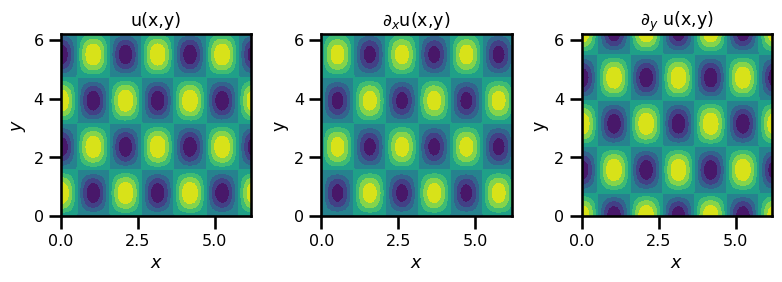

In [5]:
fig, ax = plt.subplots(ncols=3, figsize=(8,3))

ax[0].contourf(X, Y, u[:],)
ax[1].contourf(X, Y, dudx[:])
ax[2].contourf(X, Y, dudy[:])

ax[0].set(title="u(x,y)", xlabel="$x$", ylabel="$y$")
ax[1].set(title="$\partial_x $u(x,y)", xlabel="$x$", ylabel=r"y")
ax[2].set(title="$\partial_y$ u(x,y)", xlabel="$x$", ylabel="y")
plt.tight_layout()
plt.show()

#### Pseudospectral

### Functional API

In [6]:
from spectraldiffx._src.utils import calculate_fft_freq, calculate_aliasing, fft_transform
from spectraldiffx._src.difference import spectral_difference, difference

In [7]:

# calculate frequencies
k_vec = [calculate_fft_freq(Nx, Lx) for Nx, Lx in zip([Nx,Ny], [Lx,Ly])]
cond = [calculate_aliasing(ikvec) for ikvec in k_vec]
# k_vec = jnp.where(cond, 0.0, k_vec)

# Difference operator x
Fux = fft_transform(u[:], axis=0, inverse=False)
dFudx = spectral_difference(Fux, k_vec[0], axis=0, derivative=1)
dudx_spectral = fft_transform(dFudx, axis=0, inverse=True)

# Difference operator y
Fuy = fft_transform(u[:], axis=1, inverse=False)
dFudy = spectral_difference(Fuy, k_vec[1], axis=1, derivative=1)
dudy_spectral = fft_transform(dFudy, axis=1, inverse=True)


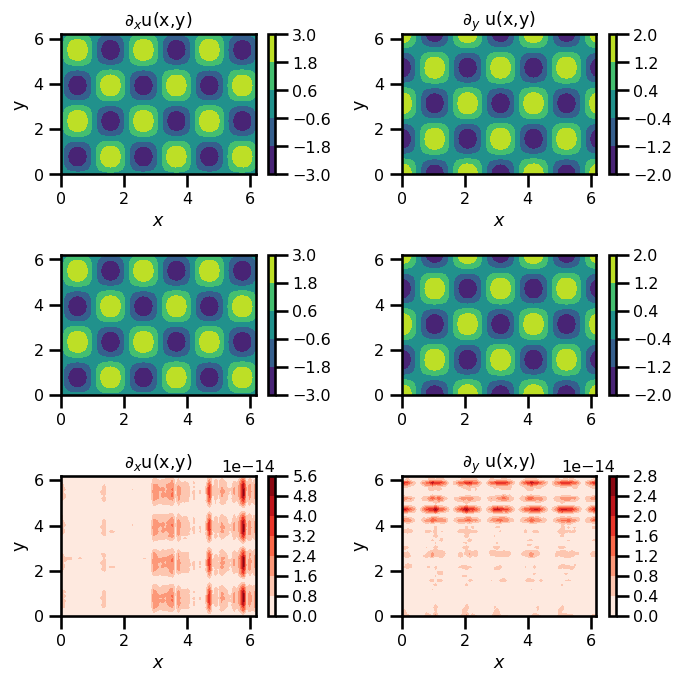

In [8]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(7,7))

x_levels = np.linspace(dudx[:].min(), dudx[:].max(), 6)
y_levels = np.linspace(dudy[:].min(), dudy[:].max(), 6)


pts = ax[0,0].contourf(X, Y, dudx[:], levels=x_levels)
plt.colorbar(pts)
pts = ax[0,1].contourf(X, Y, dudy[:], levels=y_levels)
plt.colorbar(pts)


pts = ax[1,0].contourf(X, Y, dudx_spectral[:], levels=x_levels)
plt.colorbar(pts)
pts = ax[1,1].contourf(X, Y, dudy_spectral[:], levels=y_levels)
plt.colorbar(pts)

ax[0,0].set(title="$\partial_x $u(x,y)", xlabel="$x$", ylabel=r"y")
ax[0,1].set(title="$\partial_y$ u(x,y)", xlabel="$x$", ylabel="y")

ps_err_x = np.abs(dudx[:] - dudx_spectral[:])
ps_err_y = np.abs(dudy[:] - dudy_spectral[:])

pts=ax[2,0].contourf(X, Y, ps_err_x, cmap="Reds")
plt.colorbar(pts)
pts=ax[2,1].contourf(X, Y, ps_err_y, cmap="Reds")
plt.colorbar(pts)

ax[2,0].set(title="$\partial_x $u(x,y)", xlabel="$x$", ylabel=r"y")
ax[2,1].set(title="$\partial_y$ u(x,y)", xlabel="$x$", ylabel="y")
plt.tight_layout()
plt.show()

### Simpler Functional API

In [9]:
# calculate frequencies
k_vec = [calculate_fft_freq(Nx, Lx) for Nx, Lx in zip([Nx,Ny], [Lx,Ly])]

# pseudospectral transformation
dudx_spectral = difference(u[:], k_vec=k_vec[0], axis=0)
dudy_spectral = difference(u[:], k_vec=k_vec[1], axis=1)

TypeError: spectral_difference() got an unexpected keyword argument 'real'

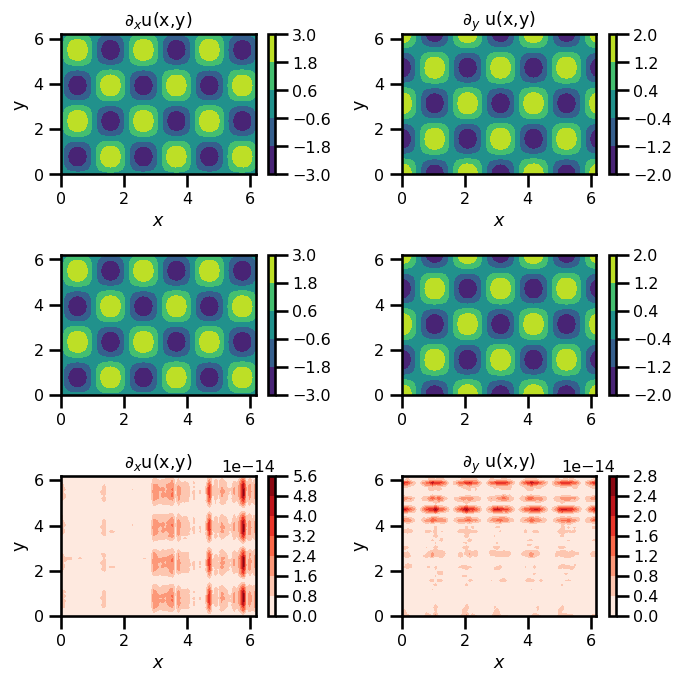

In [10]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(7,7))

x_levels = np.linspace(dudx[:].min(), dudx[:].max(), 6)
y_levels = np.linspace(dudy[:].min(), dudy[:].max(), 6)


pts = ax[0,0].contourf(X, Y, dudx[:], levels=x_levels)
plt.colorbar(pts)
pts = ax[0,1].contourf(X, Y, dudy[:], levels=y_levels)
plt.colorbar(pts)


pts = ax[1,0].contourf(X, Y, dudx_spectral[:], levels=x_levels)
plt.colorbar(pts)
pts = ax[1,1].contourf(X, Y, dudy_spectral[:], levels=y_levels)
plt.colorbar(pts)

ax[0,0].set(title="$\partial_x $u(x,y)", xlabel="$x$", ylabel=r"y")
ax[0,1].set(title="$\partial_y$ u(x,y)", xlabel="$x$", ylabel="y")

ps_err_x = np.abs(dudx[:] - dudx_spectral[:])
ps_err_y = np.abs(dudy[:] - dudy_spectral[:])

pts=ax[2,0].contourf(X, Y, ps_err_x, cmap="Reds")
plt.colorbar(pts)
pts=ax[2,1].contourf(X, Y, ps_err_y, cmap="Reds")
plt.colorbar(pts)

ax[2,0].set(title="$\partial_x $u(x,y)", xlabel="$x$", ylabel=r"y")
ax[2,1].set(title="$\partial_y$ u(x,y)", xlabel="$x$", ylabel="y")
plt.tight_layout()
plt.show()

### Operator API

In [11]:
from typing import NamedTuple, Iterable, Optional
import math

class Difference(NamedTuple):
    k_vec: Iterable[Array]
    ratio: float
    aliasing_cond: Iterable[Array]

    @classmethod
    def init(
        cls,
        N: Iterable[float],
        L: Optional[Iterable[float]] = None,
        ratio: Optional[float] = 1.0 / 3.0,
    ):
        # calculate fourier frequencies
        if isinstance(N, (float, int)):
            N = tuple(N)

        if L is None:
            L = (2 * math.pi,) * len(N)
        elif isinstance(L, (int, float)):
            L = (float(L),) * len(N)

        assert len(N) == len(L)
        k_vec = [calculate_fft_freq(N=iN, L=iL) for iN, iL in zip(N, L)]
        ratio = ratio
        aliasing_cond = [calculate_aliasing(ikvec, ratio=ratio) for ikvec in k_vec]

        return cls(k_vec=k_vec, ratio=ratio, aliasing_cond=aliasing_cond)

    def get_k_vec(self, axis: int = 0, aliasing: bool = True):
        k_vec = self.k_vec[axis]

        if aliasing:
            k_vec = jnp.where(self.aliasing_cond[axis], 0.0, k_vec)

        return k_vec

    def difference(
        self,
        u: Array,
        axis: int = 0,
        derivative: int = 1,
        aliasing: bool = True,
    ) -> Array:
        k_vec = self.get_k_vec(axis=axis, aliasing=aliasing)
        return difference(u=u, k_vec=k_vec, axis=axis, derivative=derivative)

    def transform(self, u: Array, axis: int = 0) -> Array:
        return fft_transform(u=u, axis=axis, inverse=False)

    def inverse_transform(self, u: Array, axis: int = 0) -> Array:
        return fft_transform(u=u, axis=axis, inverse=True)

    def spectral_difference(
        self, fu: Array, axis: int = 0, derivative: int = 1
    ) -> Array:
        k_vec = self.get_k_vec(axis=axis, aliasing=aliasing)
        return spectral_difference(fu=fu, k_vec=k_vec, axis=axis, derivative=derivative)

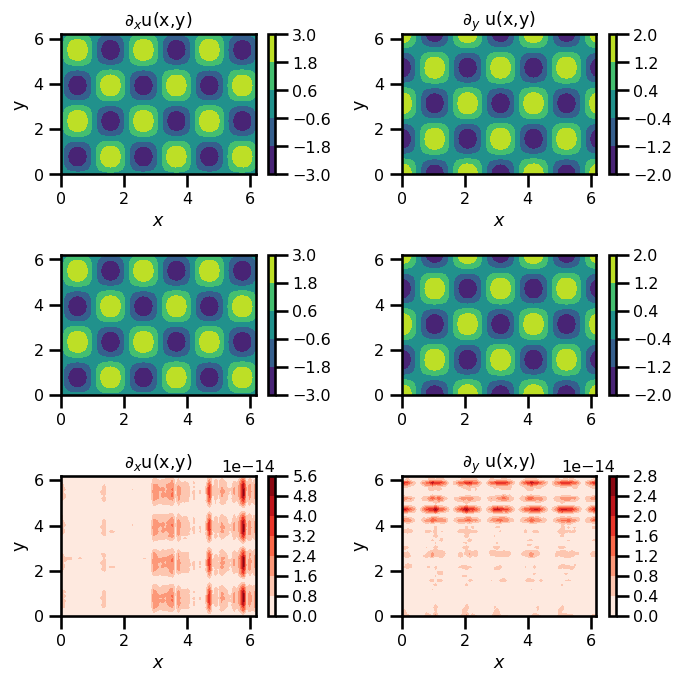

In [12]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(7,7))

x_levels = np.linspace(dudx[:].min(), dudx[:].max(), 6)
y_levels = np.linspace(dudy[:].min(), dudy[:].max(), 6)


pts = ax[0,0].contourf(X, Y, dudx[:], levels=x_levels)
plt.colorbar(pts)
pts = ax[0,1].contourf(X, Y, dudy[:], levels=y_levels)
plt.colorbar(pts)


pts = ax[1,0].contourf(X, Y, dudx_spectral[:], levels=x_levels)
plt.colorbar(pts)
pts = ax[1,1].contourf(X, Y, dudy_spectral[:], levels=y_levels)
plt.colorbar(pts)

ax[0,0].set(title="$\partial_x $u(x,y)", xlabel="$x$", ylabel=r"y")
ax[0,1].set(title="$\partial_y$ u(x,y)", xlabel="$x$", ylabel="y")

ps_err_x = np.abs(dudx[:] - dudx_spectral[:])
ps_err_y = np.abs(dudy[:] - dudy_spectral[:])

pts=ax[2,0].contourf(X, Y, ps_err_x, cmap="Reds")
plt.colorbar(pts)
pts=ax[2,1].contourf(X, Y, ps_err_y, cmap="Reds")
plt.colorbar(pts)

ax[2,0].set(title="$\partial_x $u(x,y)", xlabel="$x$", ylabel=r"y")
ax[2,1].set(title="$\partial_y$ u(x,y)", xlabel="$x$", ylabel="y")
plt.tight_layout()
plt.show()

## Extracting Linear Operators

In [13]:
def f(x, y, Lx, Ly, mx, my):
    return jnp.cos(mx* 2 * jnp.pi * x / Lx) * jnp.sin(my * 2*jnp.pi*y / Ly)

# define gradient functions
df_dx = jax.grad(f, argnums=0)
df_dy = jax.grad(f, argnums=1)

# second order functions
d2f_dx2 = jax.grad(df_dx)
d2f_dy2 = jax.grad(df_dy)

In [14]:

kernel = lambda x,y: f(x,y,Lx,Ly,mx,my)
kernel_grad_x = lambda x,y: df_dx(x,y,Lx,Ly,mx,my)
kernel_grad_y = lambda x,y: df_dy(x,y,Lx,Ly,mx,my)
kernel_grad2_x2 = lambda x,y: d2f_dx2(x,y,Lx,Ly,mx,my)
kernel_grad2_y2 = lambda x,y: d2f_dy2(x,y,Lx,Ly,mx,my)

def gram_matrix(f, x, y):
    return jax.vmap(lambda x: jax.vmap(lambda y: f(x, y))(y))(x)

u = gram_matrix(kernel, x_coords, y_coords)
dudx = gram_matrix(kernel_grad_x, x_coords, y_coords)
dudy = gram_matrix(kernel_grad_y, x_coords, y_coords)
d2udx2 = gram_matrix(kernel_grad2_x2, x_coords, y_coords)
d2udy2 = gram_matrix(kernel_grad2_y2, x_coords, y_coords)

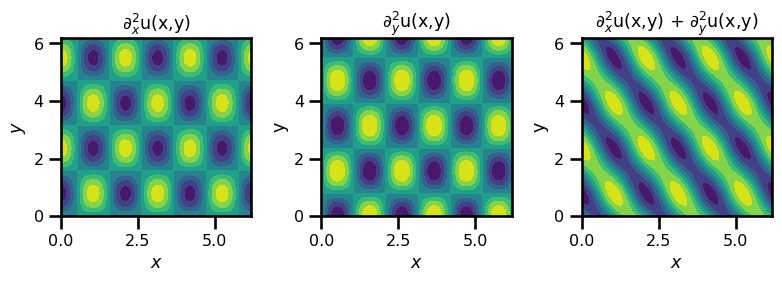

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(8,3))

ax[0].contourf(X, Y, d2udx2[:],)
ax[1].contourf(X, Y, d2udy2[:])
ax[2].contourf(X, Y, d2udx2 + d2udy2)

ax[0].set(title="$\partial^2_x $u(x,y)", xlabel="$x$", ylabel="$y$")
ax[1].set(title="$\partial^2_y $u(x,y)", xlabel="$x$", ylabel=r"y")
ax[2].set(title="$\partial^2_x $u(x,y) + $\partial^2_y $u(x,y)", xlabel="$x$", ylabel="y")
plt.tight_layout()
plt.show()

In [16]:
from spectraldiffx._src.operators import calculate_operators

In [28]:
# d2udx2_spectral = diff_op.difference(u, axis=0, derivative=2)
# d2udy2_spectral = diff_op.difference(u, axis=1, derivative=2)
# # np.testing.assert_array_almost_equal(d2udx2_spectral, d2udy2_spectral)
real = False
# calculate frequencies
k_vec = [calculate_fft_freq(Nx, Lx, real=real) for Nx, Lx in zip([Nx,Ny], [Lx,Ly])]
cond = [calculate_aliasing(ikvec) for ikvec in k_vec]
k_vec = [jnp.where(icond, 0.0, ikvec) for icond, ikvec in zip(cond,k_vec)]

# Difference operator x
Fux = fft_transform(u[:], axis=0, inverse=False, real=real)
d2Fudx2 = spectral_difference(Fux, k_vec[0], axis=0, derivative=2)
d2udx2_spectral = jnp.real(fft_transform(d2Fudx2, axis=0, inverse=True, real=real))

# Difference operator y
Fuy = fft_transform(u[:], axis=1, inverse=False, real=real)
d2Fudy2 = spectral_difference(Fuy, k_vec[1], axis=1, derivative=2)
d2udy2_spectral = jnp.real(fft_transform(d2Fudy2, axis=1, inverse=True, real=real))

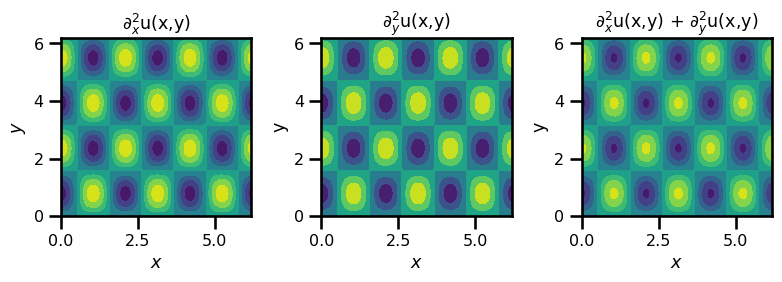

In [29]:
fig, ax = plt.subplots(ncols=3, figsize=(8,3))

ax[0].contourf(X, Y, d2udx2_spectral[:],)
ax[1].contourf(X, Y, d2udy2_spectral[:])
ax[2].contourf(X, Y, d2udx2_spectral + d2udy2_spectral)

ax[0].set(title="$\partial^2_x $u(x,y)", xlabel="$x$", ylabel="$y$")
ax[1].set(title="$\partial^2_y $u(x,y)", xlabel="$x$", ylabel=r"y")
ax[2].set(title="$\partial^2_x $u(x,y) + $\partial^2_y $u(x,y)", xlabel="$x$", ylabel="y")
plt.tight_layout()
plt.show()

In [19]:
def calculate_fft_freq_(Nx: int, Lx: float = 2.0 * math.pi) -> Array:
    """a helper function to generate 1D FFT frequencies

    Args:
        Nx (int): the number of points for the grid
        Lx (float): the distance for the points along the grid

    Returns:
        freq (Array): the 1D fourier frequencies
    """
    # return jnp.fft.fftfreq(n=Nx, d=Lx / (2.0 * math.pi * Nx))
    return (2 * math.pi / Lx) * jnp.fft.fftfreq(n=Nx, d=Lx / (Nx * 2.0 * math.pi))

In [20]:
k_vec = [calculate_fft_freq_(n,l) for n,l in zip([Nx,Ny],[Lx,Ly])]
K, L = [jnp.expand_dims(array, axis=i) for i, array in enumerate(k_vec)]

In [21]:
import functools as ft

order = 1

# expand each of the dimensions
ks = [jnp.expand_dims(array, axis=i) for i, array in enumerate(k_vec)]

# sum each of dimensions
ksq = ft.reduce(lambda x, y: x ** (2 * order) + y ** (2 * order), ks)

ksq = ksq.T

In [22]:
Fu = np.fft.fftn(u) 

lap_Fu = ksq @ Fu

u_lap = np.real(np.fft.ifftn(lap_Fu))

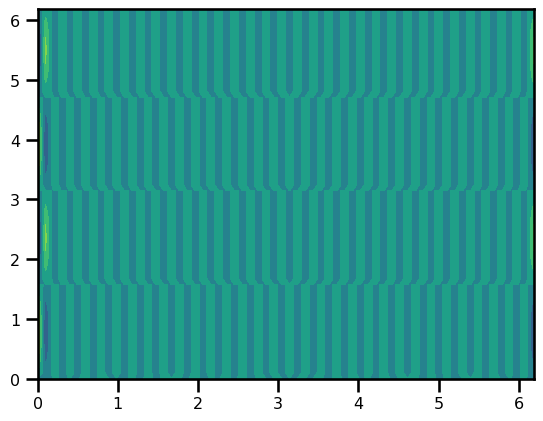

In [23]:
plt.contourf(X,Y, u_lap)